# Setup

## Matrix-box rundt om tand: 

### 15 \times 15 giver 96%, (Kvadrat) På Nye billeder 25K

### 10 width og 25 height giver også 96%

### 8 width 12 height giver også 96%

In [1]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go


# === CONFIGURATION ===
# === PATHS (relative) ===
csv_path = os.path.join("..", "Output", "Keypoint Placement", "KP_Placement.csv")
image_folder = os.path.join("..", "..", "Data", "Clean Data", "Overbite Data", "Annotated Test data")
output_csv_path = os.path.join("..", "Output", "Pixel Matrix", "KP_Refinement.csv")

# === LOAD CSV ===
df = pd.read_csv(csv_path)

# Prepare a list to store new refined points
refined_data = []

# === UTILITY FUNCTION ===
def refine_guess_with_pixel_matrix(image, x_center, y_center, window_width=12, window_height=8):
    try:
        
        half_width = window_width // 2
        half_height = window_height // 2
        
        # set the search window within the image bounds
        x_min = int(max(x_center - half_width, 0))
        x_max = int(min(x_center + half_width + 1, image.shape[1]))
        y_min = int(max(y_center - half_height, 0))
        y_max = int(min(y_center + half_height + 1, image.shape[0]))
        
        # create a sub-image for the search window
        sub_img = image[y_min:y_max, x_min:x_max]
        
        # convert to grayscale and find non-black pixels
        gray = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
        non_black_pixels = np.argwhere(gray > 0)
        if len(non_black_pixels) == 0:
            return x_center, y_center, window_height, window_width  # Always return 4 
        
        # find the topmost non-black pixel
        top_y = np.min(non_black_pixels[:, 0])
        top_pixels = non_black_pixels[non_black_pixels[:, 0] == top_y]
        
        # find the pixel with the highest brightness among the topmost pixels
        brightness = [gray[pt[0], pt[1]] for pt in top_pixels]
        brightest_idx = np.argmax(brightness)
        top_pixel = top_pixels[brightest_idx]
        
        # calculate the refined coordinates in the original image
        refined_x = x_min + top_pixel[1]
        refined_y = y_min + top_pixel[0]
        return refined_x, refined_y, window_height, window_width  # Always return 4
    except Exception as e:
        print(f"[Function Error] Failed refinement at ({x_center},{y_center}) -> Error: {e}")
        return x_center, y_center, window_height, window_width  # Safe fallback

# === MAIN LOOP ===

# Iterate through each row in the DataFrame (the csv file with the keypoints)
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['Filename'] + ".png"
    img_path = os.path.join(image_folder, filename)
    if not os.path.exists(img_path):
        print(f"[Missing File] {filename}")
        continue
    
    image = cv2.imread(img_path)
    if image is None or image.shape[0] == 0 or image.shape[1] == 0:
        print(f"[Invalid Image] {filename}")
        continue
    
    # get the model keypoint guess
    x_model = int(row['X_Model'])
    y_model = int(row['Y_Model'])

    # Apply the pixel matrix refinement function
    try:
        x_refined, y_refined, used_window_height, used_window_width = refine_guess_with_pixel_matrix(
            image, x_model, y_model
        )
    except Exception as e:
        print(f"[Loop Error] Index {idx} - {filename}: {e}")
        continue  

    # Load image
    im = cv2.imread(img_path)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    height, width = im.shape[:2]

    # Set keypoints: True, Model, Refined
    x_true, y_true = row['X_True'], row['Y_True']
    x_model, y_model = int(row['X_Model']), int(row['Y_Model'])
    x_refined, y_refined = int(x_refined), int(y_refined)

    # === Start Plotly Figure ===
    fig = go.Figure()

    # --- Background Image ---
    fig.add_trace(go.Image(z=im_rgb, name="Image"))

    # --- True Keypoint (Green) ---
    fig.add_trace(go.Scatter(
        x=[x_true], y=[y_true],
        mode='markers+text',
        name="True Keypoint",
        text=["True"],
        textposition="top right",
        marker=dict(color='green', size=5),
        showlegend=True
    ))

    # --- Model Guess Keypoint (Red) ---
    fig.add_trace(go.Scatter(
        x=[x_model], y=[y_model],
        mode='markers+text',
        name="Model Guess",
        text=["Model"],
        textposition="top right",
        marker=dict(color='red', size=5),
        showlegend=True
    ))

    # --- Refined Keypoint (Blue) ---
    fig.add_trace(go.Scatter(
        x=[x_refined], y=[y_refined],
        mode='markers+text',
        name="Refined Keypoint",
        text=["Refined"],
        textposition="top right",
        marker=dict(color='blue', size=5),
        showlegend=True
    ))

    # --- Rectangular Pixel Search Window (Yellow BBox) ---
    half_width = used_window_width // 2
    half_height = used_window_height // 2

    bbox_x0 = x_model - half_width
    bbox_y0 = y_model - half_height
    bbox_x1 = x_model + half_width
    bbox_y1 = y_model + half_height

    # Define bounding box as line loop
    fig.add_trace(go.Scatter(
        x=[bbox_x0, bbox_x1, bbox_x1, bbox_x0, bbox_x0],
        y=[bbox_y0, bbox_y0, bbox_y1, bbox_y1, bbox_y0],
        mode='lines',
        name=f"{used_window_width}x{used_window_height} Window",
        line=dict(color='yellow', dash='dash', width=1),
        showlegend=True
    ))


    # === Layout ===
    fig.update_layout(
        title=f"Pixel Matrix Refinement: {row['Filename']}",
        xaxis=dict(visible=False, range=[0, width], scaleanchor="y", constrain="domain"),
        yaxis=dict(visible=False, range=[height, 0], scaleanchor="x", constrain="domain"),
        showlegend=True,
        height=height,
        width=width,
        margin=dict(l=0, r=0, t=40, b=0),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    #fig.show(renderer="browser")
    # Create output folder if needed
    output_html_dir = os.path.join("..", "Output", "Pixel Matrix", "Image Output")
    os.makedirs(output_html_dir, exist_ok=True)

    # Save to HTML
    html_path = os.path.join(output_html_dir, f"{row['Filename']}.html")
    fig.write_html(html_path)


    # === Append Data ===
    refined_data.append({
        'Filename': row['Filename'],
        'X_Model': x_model,
        'Y_Model': y_model,
        'X_Refined': x_refined,
        'Y_Refined': y_refined,
        'X_True': row['X_True'],
        'Y_True': row['Y_True']
    })


# === SAVE OUTPUT ===
refined_df = pd.DataFrame(refined_data)
refined_df.to_csv(output_csv_path, index=False)
print(f"Saved refined results to {output_csv_path}")


100%|██████████| 300/300 [00:24<00:00, 12.43it/s]

Saved refined results to ..\Output\Pixel Matrix\KP_Refinement.csv


# Calculate the distance

In [2]:
import pandas as pd
import numpy as np
import os

# === CONFIG ===
csv_path = os.path.join("..", "Output", "Pixel Matrix", "KP_Refinement.csv")
output_path = os.path.join("..", "Output", "Pixel Matrix", "KP_Refinement_Distance.csv")

# Pixel to mm scale
PIXEL_TO_MM = 0.08

# === Load CSV ===
df = pd.read_csv(csv_path)

# === Calculate Distances ===
dx = df['X_Refined'] - df['X_True']
dy = df['Y_Refined'] - df['Y_True']
df['Refined_Pixel_Dist'] = np.sqrt(dx**2 + dy**2)
df['Refined_mm_Dist'] = df['Refined_Pixel_Dist'] * PIXEL_TO_MM

# === Save New CSV ===
df.to_csv(output_path, index=False)
print(f"Distance-calculated CSV saved to:\n{output_path}")


Distance-calculated CSV saved to:
..\Output\Pixel Matrix\KP_Refinement_Distance.csv


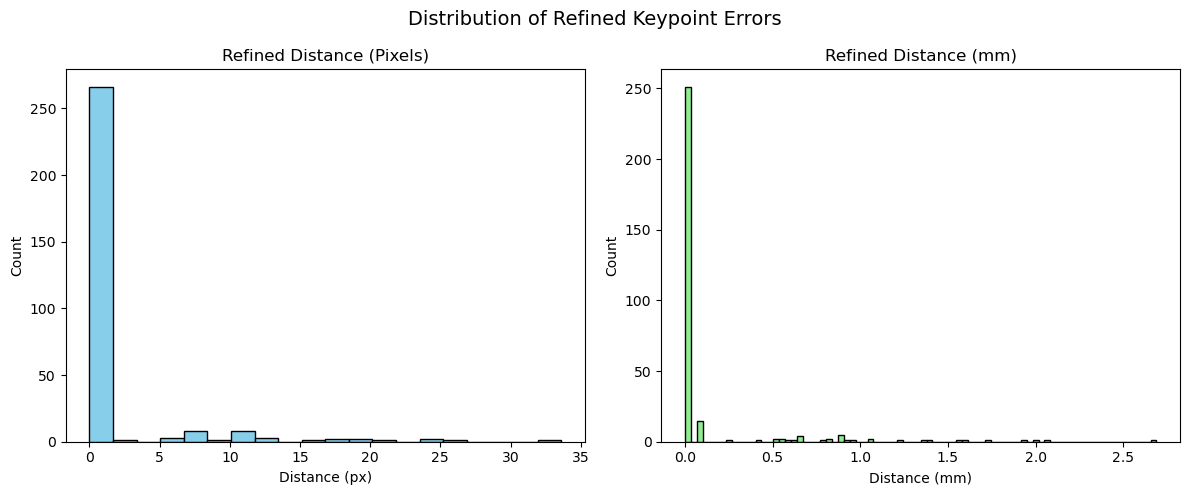

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# === Load refined CSV with distances ===
df = pd.read_csv(os.path.join("..", "Output", "Pixel Matrix", "KP_Refinement_Distance.csv"))

# === Plot histogram ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Pixel Distance Histogram
ax[0].hist(df['Refined_Pixel_Dist'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title("Refined Distance (Pixels)")
ax[0].set_xlabel("Distance (px)")
ax[0].set_ylabel("Count")

# --- Millimeter Distance Histogram
ax[1].hist(df['Refined_mm_Dist'], bins=80, color='lightgreen', edgecolor='black')
ax[1].set_title("Refined Distance (mm)")
ax[1].set_xlabel("Distance (mm)")
ax[1].set_ylabel("Count")

plt.suptitle("Distribution of Refined Keypoint Errors", fontsize=14)
plt.tight_layout()
plt.show()
